In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from helpers.descriptors import average_directed_distance, Section


In [175]:
# load a section . 
X = np.loadtxt("../../real_data/16_Archamps/process/sections_as_polylines/Meandre_1_reordered_2d_011.txt")


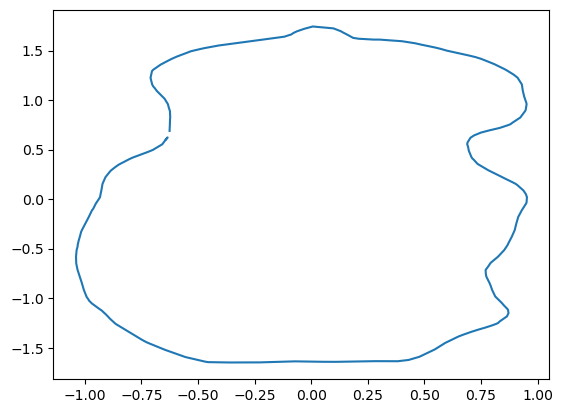

In [176]:
plt.plot(X[:, 0], X[:, 1])

In [177]:
def CoG(s, verbose = False):
    n = len(s)
    # where s is the clockwise path determining the ngon by pairs of coordinates. 
    denominator = np.zeros(n-2)
    numerator = np.zeros((n-2, 2))
    
    # determinant method (see: https://math.stackexchange.com/questions/90463/how-can-i-calculate-the-centroid-of-polygon)
    u = s[1:-1] - s[0]
    v = s[2:] - s[0]
    
    dets = u[:, 0]* v[:, 1] - u[:, 1]*v[:, 0]
    centroids = (s[0]+s[1:-1]+s[2:]) / 3
    numerator = np.sum(np.multiply(np.expand_dims(dets, -1), centroids), axis = 0) 
    denominator = np.sum(dets)

    cog = numerator / denominator
    if verbose == True:
        print("estimated area",  np.abs(np.sum(u[:, 0]* v[:, 1] - u[:, 1]*v[:, 0]))/ 2)
    return cog

In [178]:
def area(x):
    x1, x2 = x.T
    # use of triangles and determinants to compute the area. 
    return 0.5* np.abs(np.dot(x1,np.roll(x2,1))-np.dot(x2,np.roll(x1,1)))

In [179]:
G = CoG(X)
A = area(X)

In [180]:
Sigma =  1 / A * (X-G).T @ (X-G)

In [181]:
D, S = np.linalg.eig(Sigma)
D = np.diag(D)

In [182]:
S

array([[-0.99560525, -0.09364927],
       [ 0.09364927, -0.99560525]])

In [183]:
# transform the ellipse in a new basis. 

X_prime = S.T @ (X-G).T

In [184]:
X_prime

array([[ 0.69049303,  0.68662108,  0.68496746, ...,  0.68251735,
         0.68243335,  0.68247824],
       [-0.59086944, -0.60335757, -0.61047347, ..., -0.67881147,
        -0.6779169 , -0.6768948 ]])

In [185]:
def makeEllipse(a, b, theta):
    t = np.linspace(-np.pi, np.pi, 200)

    xy = np.vstack([a*np.cos(t), b*np.sin(t)]).T

    rot = np.array([[np.cos(theta),-np.sin(theta)],
                      [np.sin(theta),np.cos(theta)]]).astype(np.float32)

    return np.dot(xy, rot)
    

In [186]:
ratio = np.sqrt(D[0,0]) / np.sqrt(D[1,1])
_lambda = np.sqrt(A  / (np.sqrt(np.linalg.det(Sigma))*np.pi))
ell = makeEllipse(_lambda * np.sqrt(D[0,0]), _lambda * np.sqrt(D[1,1]), 0)

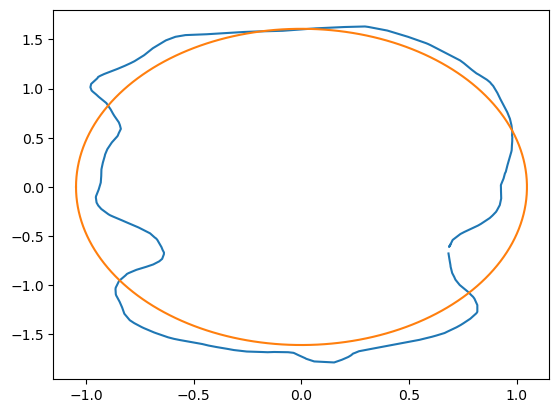

In [187]:
fig, ax = plt.subplots()

ax.plot(X_prime[0], X_prime[1])
ax.plot(ell.T[0], ell.T[1])

In [188]:
def directed_distance(S1, S2, ord = 1):
    S1toS2 = np.min(np.linalg.norm(np.expand_dims(S2, 1) - S1, axis = 2).T, axis = 1)**ord
    return np.mean(S1toS2)

In [189]:
def directed_distances(S1, S2, ord = 1):
    S1toS2 = np.min(np.linalg.norm(np.expand_dims(S2, 1) - S1, axis = 2).T, axis = 1)**ord
    return S1toS2

In [190]:
directed_distance(X_prime.T, ell, ord=1)

0.11745148643560517

In [191]:
def objective(p, pts):
    ell = makeEllipse(*p)
    return directed_distance(ell, pts, ord=1)

In [192]:
def objective_to(p, pts):
    ell = makeEllipse(*p)
    return directed_distance(pts, ell, ord = 1)

In [193]:
def objective_average(p, pts):
    ell = makeEllipse(*p)
    return average_directed_distance(pts, ell)

In [194]:
res = minimize(objective, [ratio, 1, 0], X_prime.T, method = 'Nelder-Mead')
res2 = minimize(objective_to, [ratio,1, 0], X_prime.T, method = 'Nelder-Mead')
resavg = minimize(objective_average, [ratio,1, 0], X_prime.T, method = 'Nelder-Mead')

In [195]:
fitted = makeEllipse(*res.x)
fitted2 = makeEllipse(*res2.x)
fitted_avg = makeEllipse(*resavg.x)

In [196]:
directed_distance(fitted, X_prime.T)

0.07482919249204201

In [197]:
directed_distance(X_prime.T, fitted)

0.08814840440305818

In [198]:
directed_distance(fitted2, X_prime.T)

0.07723546469695085

In [199]:
directed_distance(X_prime.T, fitted2)

0.08527244405830293

In [200]:
res2

 final_simplex: (array([[0.95396528, 1.77583387, 0.01022363],
       [0.95390163, 1.77589991, 0.01025986],
       [0.95403017, 1.77588398, 0.01025801],
       [0.95391106, 1.77582651, 0.01031965]]), array([0.08527244, 0.08527247, 0.08527251, 0.08527251]))
           fun: 0.08527244405830293
       message: 'Optimization terminated successfully.'
          nfev: 150
           nit: 87
        status: 0
       success: True
             x: array([0.95396528, 1.77583387, 0.01022363])

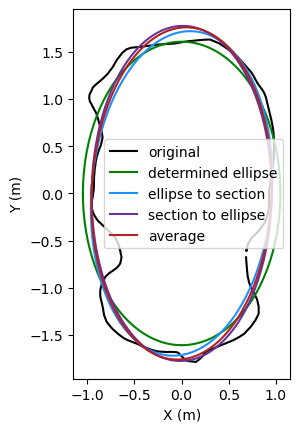

In [201]:
fig, ax = plt.subplots()

ax.plot(X_prime.T[:,  0], X_prime.T[:, 1], color = "k", label = "original")
ax.plot(ell[:, 0], ell[:, 1], color = "green", label = "determined ellipse")

ax.plot(fitted[:, 0], fitted[:, 1], color = "dodgerblue", label = "ellipse to section")
ax.plot(fitted2[:, 0], fitted2[:, 1], color = "rebeccapurple", label = "section to ellipse")
ax.plot(fitted_avg[:, 0], fitted_avg[:, 1], color = "firebrick", label = "average")

ax.set_aspect("equal")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.legend()
plt.savefig("M:PostDoc/Ellipses_1_Meandre.png", dpi = 300)

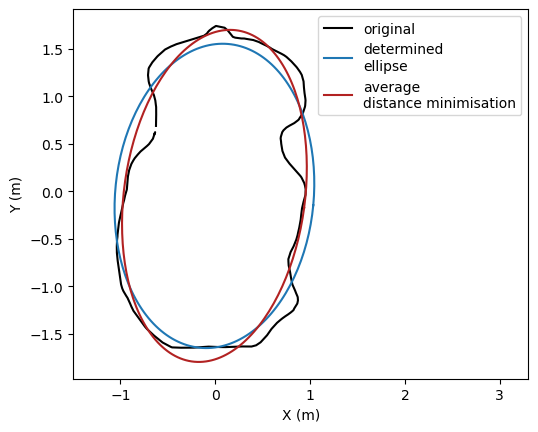

In [208]:
fig, ax = plt.subplots()

# retransform: 

ell_prime = (S @ ell.T).T + G
fitted_prime = (S @ fitted.T).T +G
fitted_prime_2 = (S @ fitted2.T).T +G
fitted_avg_prime = (S @ fitted_avg.T).T + G

ax.plot(X[:,  0], X[:, 1], color = "k", label = "original")
ax.plot(ell_prime[:, 0], ell_prime[:, 1], color = "C0", label = "determined\nellipse")

#ax.plot(fitted_prime[:, 0], fitted_prime[:, 1], color = "dodgerblue", label = "ellipse to section")
#ax.plot(fitted_prime_2[:, 0], fitted_prime_2[:, 1], color = "rebeccapurple", label = "section to ellipse")
ax.plot(fitted_avg_prime[:, 0], fitted_avg_prime[:, 1], color = "firebrick", label = "average\ndistance minimisation")

ax.set_aspect("equal")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_xlim(-1.5, 3.3)
ax.legend()
plt.savefig("M:PostDoc/Ellipses_1_Meandre.png", dpi = 300)

In [275]:
# example of directed distance. 
t = np.linspace(-np.pi, np.pi, 200)
a = np.ones(len(t))
a[110:120] = 1.5

b = np.ones(len(t))
b[110:120] = 2
circle1 = np.vstack([0.9* np.cos(t), 0.9* np.sin(t)]).T
circle2 = np.vstack([a*np.cos(t), a*np.sin(t)]).T
circle3 = np.vstack([b*np.cos(t), b*np.sin(t)]).T


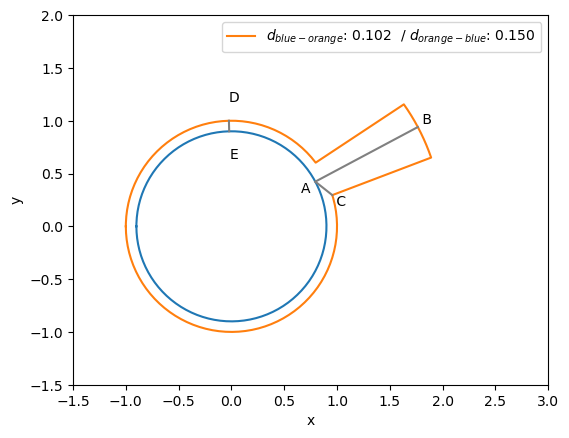

In [318]:
fig, ax = plt.subplots()

ax.plot(circle1[:, 0], circle1[:, 1], )
ax.plot(circle3[:, 0], circle3[:, 1], label =f"$d_{{blue-orange}}$: {directed_distance(circle1, circle3):.3f}  / $d_{{orange-blue}}$: {directed_distance(circle3, circle1):.3f}")
ax.legend()
ax.set_aspect("equal")
ax.set_xlim(-1.5, 3)
ax.set_ylim(-1.5, 2)
example = np.vstack([circle1[115],circle3[115]])
example2 = np.vstack([circle1[115],circle3[109]])
example3  = np.vstack([circle1[150],circle3[150]])
ax.plot(example[:, 0], example[:, 1], "-", color = "grey")
ax.plot(example2[:, 0], example2[:, 1], "-", color = "grey")
ax.plot(example3[:, 0], example3[:, 1], "-", color = "grey")
ax.text(*circle1[115], "A ", va= "top", ha = "right")
ax.text(*circle3[115], " B", va= "bottom", ha = "left")
ax.text(*circle3[109], " C", va= "top", ha = "left")
ax.text(*circle3[150], "D\n", va= "bottom", ha = "left")
ax.text(*circle1[150], "\nE", va= "top", ha = "left")

ax.set_xlabel("x")
ax.set_ylabel("y")

plt.savefig("M:PostDoc/DirectedDistance.png", dpi = 300)

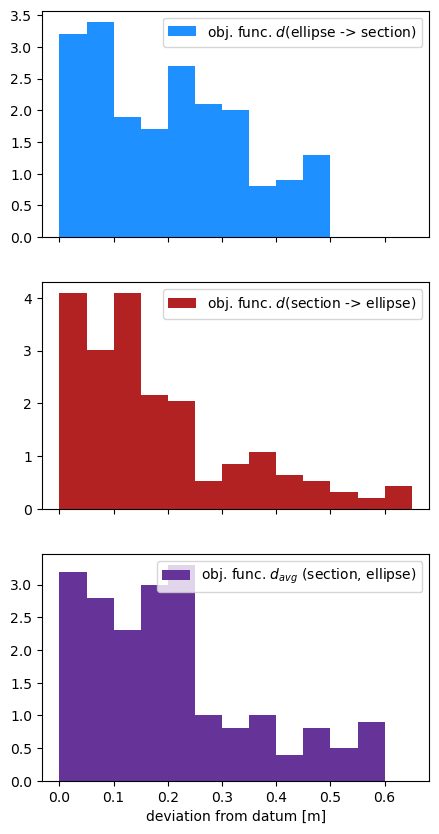

In [348]:
# comparison histograms from the selected distances. 
dir_dists = directed_distances(fitted, section)
dir_dists2 = directed_distances(fitted2, section)
dir_dists_avg = directed_distances(fitted_avg, section)

fig, axes = plt.subplots(3, 1, figsize = (5, 10), sharex = True)
axes[0].hist(dir_dists, bins = np.arange(0, 0.7, 0.05), color = "dodgerblue", density = True, label = "obj. func. $d$(ellipse -> section)")
axes[1].hist(dir_dists2, bins = np.arange(0, 0.7, 0.05), color = "firebrick", density = True,  label = "obj. func. $d$(section -> ellipse)")
axes[2].hist(dir_dists_avg, bins = np.arange(0, 0.7, 0.05), color = "rebeccapurple", density = True,  label = "obj. func. $d_{avg}$ (section, ellipse)")
axes[2].set_xlabel("deviation from datum [m]")

for ax in axes:
    ax.legend()

plt.savefig("M:PostDoc/deviation_from_datum_histograms.png", dpi = 300)

In [ ]:
HausdorffDistance(circle2, circle1)

In [ ]:
HausdorffDistance(circle1, circle3)

In [ ]:
HausdorffDistance(circle3, circle1)